## 🛠 Importing Required Libraries

In [72]:
import torch,json,os
import matplotlib.pyplot as plt
from torchvision import datasets,transforms
import torchvision.models as models
from pathlib import Path
import torch.nn as nn
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import numpy as np


## 📂 Dataset Path & Image Collection

In [3]:
image_dir = r"C:\Users\thaku\jupyter notebook datasets\Fashion Recommender System\Dataset\fashion-dataset\images"
all_images = [f for f in os.listdir(image_dir) if f.endswith(('.jpg','.png','.jpeg'))]

In [4]:
len(all_images)
all_images[:5]

['10000.jpg', '10001.jpg', '10002.jpg', '10003.jpg', '10004.jpg']

## 🖼️ Visualizing Sample Images

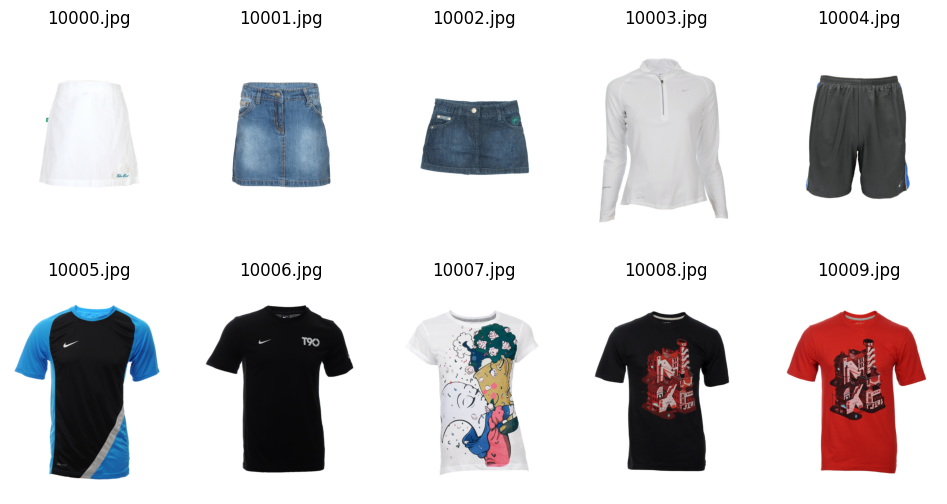

In [5]:
plt.figure(figsize=(12,6))
for i,img in enumerate(all_images[:10]):
    try:
        path = os.path.join(image_dir,img)
        image = Image.open(path).convert("RGB")
        plt.subplot(2,5,i+1)
        plt.imshow(image)
        plt.title(img)
        plt.axis("off")
    except Exception as e:
        print(f"Error with {img_name}: {e}")
plt.show()

## 🗂️ Custom Fashion Dataset Class

### 🔹 Defining `FashionDataset` for Image Pairs

In [21]:
class FashionDataset(Dataset):
    def __init__(self,img_dir,transform=None):
        self.img_dir=img_dir
        self.files = [f for f in os.listdir(img_dir) if f.endswith((".jpg",".png",".jpeg"))]
        self.transform=transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.files[idx])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img1=self.transform(img)
            img2 = self.transform(img)
        
        return img1,img2

## 🧠 Transfer Learning with ResNet50
### 🔹 Freezing Layers & Fine-Tuning the Last Block
### 🔹 Building a Modified ResNet Feature Extractor

We use a pretrained **ResNet50** model, freeze earlier layers to retain generic features, 
and fine-tune only the last block (`layer4`).  
The final layers are replaced with an **Adaptive Average Pooling** + **Flatten** operation 
to extract compact feature embeddings for fashion items.

In [22]:
weights=models.ResNet50_Weights.DEFAULT 
resnet = models.resnet50(weights=weights) 
for param in resnet.parameters(): 
    param.requires_grad=False 
for param in resnet.layer4.parameters(): 
    param.requires_grad=True 
modules = list(resnet.children())[:-2] 
modified_resnet = nn.Sequential(*modules, nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())


## 🎨 Data Augmentation for SimCLR
We apply **strong augmentations** to fashion images to create positive pairs for contrastive learning.  
Transformations include random crops, flips, color jittering, grayscale conversion, Gaussian blur, and normalization.

---

## 🔗 Projection Head Network
After extracting features from ResNet50 (2048-dim),  
we pass them through a **2-layer MLP** with ReLU activation to obtain 256-dimensional embeddings  
for the **contrastive loss function**.

In [23]:
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

projection_head = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Linear(512, 256)
)

## 🧩 Fashion Encoder Model
We define the **FashionEncoder** class that combines:

- 🏗️ **Encoder** → Modified ResNet50 (feature extractor)
- 🔗 **Projection Head** → MLP for mapping features into a contrastive embedding space
- 🧮 **L2 Normalization** → Ensures embeddings lie on the unit hypersphere for stability in contrastive loss

In [29]:
import torch.nn.functional as F
import torch.optim as optim
class FashionEncoder(nn.Module):
    def __init__(self, encoder, projection_head):
        super(FashionEncoder, self).__init__()
        self.encoder = encoder
        self.projection_head = projection_head

    def forward(self, x):
        features = self.encoder(x)                   
        projections = self.projection_head(features) 
        projections = F.normalize(projections, dim=1)
        return features, projections
model =FashionEncoder(modified_resnet,projection_head)

## 📉 Contrastive Loss (NT-Xent)
We define the **Normalized Temperature-scaled Cross Entropy Loss (NT-Xent)**:

- 🔥 **Temperature scaling** → sharpens similarity distribution  
- 🔗 **Similarity matrix** → dot product between embeddings  
- 🏷️ **Labels** → enforce that each sample matches only its positive pair  

This encourages **positive pairs** (two augmentations of the same image) to stay close while pushing **negative pairs** (different images) apart.


In [30]:
def loss(x,y,temperature=0.5):
    batch_size=x.shape[0]
    sim_matrix = torch.matmul(x,y.T)/temperature
    labels = torch.arange(batch_size).to(x.device)
    loss = F.cross_entropy(sim_matrix,labels)
    return loss

### 🏋️ Training Function for SimCLR (with NT-Xent Loss)

In [ ]:
def train(model, dataloader, optimizer, device, epochs=10, temperature=0.5):
    model.to(device)
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0.0
        
        # 🔄 Training Loop
        for (img1, img2) in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            
            # 📥 Move data to device
            img1, img2 = img1.to(device), img2.to(device)

            # 🧠 Forward pass (encoder + projection head)
            _, z1 = model(img1)
            _, z2 = model(img2)

            # 🎯 Contrastive Loss (NT-Xent)
            l = nt_xent_loss(z1, z2, temperature=temperature)

            # 📉 Backpropagation
            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            total_loss += l.item()
        
        # 📝 Epoch Loss Summary
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

### 🚀 Running the Training Pipeline

In [33]:
if __name__ == "__main__":
    img_dir = r"C:\Users\thaku\jupyter notebook datasets\Fashion Recommender System\Dataset\fashion-dataset\images"

    dataset = FashionDataset(img_dir, transform=simclr_transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0,drop_last=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    optimizer = optim.Adam(
        list(model.projection_head.parameters()) + list(resnet.layer4.parameters()),
        lr=1e-3
    )

    train(model, dataloader, optimizer, device, epochs=5)

    # Save trained encoder
    torch.save(model.encoder.state_dict(), "fashion_encoder.pth")

Epoch 1/5: 100%|█████████████████████████████████████████████████████████████████| 1388/1388 [5:00:32<00:00, 12.99s/it]


Epoch 1, Loss: 1.9429


Epoch 2/5: 100%|█████████████████████████████████████████████████████████████████| 1388/1388 [4:58:16<00:00, 12.89s/it]


Epoch 2, Loss: 1.8887


Epoch 3/5: 100%|█████████████████████████████████████████████████████████████████| 1388/1388 [5:03:22<00:00, 13.11s/it]


Epoch 3, Loss: 1.8717


Epoch 4/5: 100%|█████████████████████████████████████████████████████████████████| 1388/1388 [4:56:33<00:00, 12.82s/it]


Epoch 4, Loss: 1.8587


Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████| 1388/1388 [4:47:52<00:00, 12.44s/it]


Epoch 5, Loss: 1.8531


## 📂 Dataset Class for Inference 

In [77]:
class FashionDataset2(Dataset):
    def __init__(self,img_dir,transform=None):
        self.img_dir=img_dir
        self.files = [f for f in os.listdir(img_dir) if f.endswith((".jpg",".png",".jpeg"))]
        self.transform=transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir,self.files[idx])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.files[idx] 

## 🧹 Preprocessing Pipeline for Feature Extraction (Inference)

In [76]:
preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
               mean=[0.485, 0.456, 0.406],
               std=[0.229, 0.224, 0.225])
])

In [58]:
image_dir = r"C:\Users\thaku\jupyter notebook datasets\Fashion Recommender System\Dataset\fashion-dataset\images"
dataset1 = FashionDataset2(image_dir,transform=preprocess)
dataloader2 = DataLoader(dataset1,batch_size=32,shuffle=False,num_workers=0)

In [75]:
# -------------------------------
# 1. Import ResNet50 (no weights)
# -------------------------------
resnet = models.resnet50(weights=None)

# -------------------------------
# 2. Extract Feature Layers
# -------------------------------
modules = list(resnet.children())[:-2]

# -------------------------------
# 3. Build Encoder
# -------------------------------
encoder = nn.Sequential(
    *modules,
    nn.AdaptiveAvgPool2d((1,1)),  # Global Average Pooling
    nn.Flatten()                  # Flatten to (batch, features)
)

# -------------------------------
# 4. Load Pretrained Weights
# -------------------------------
encoder.load_state_dict(
    torch.load("fashion_encoder.pth", map_location="cpu")
)

# -------------------------------
# 5. Set Evaluation Mode
# -------------------------------
encoder.eval()


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [78]:
image_dir = r"C:\Users\thaku\jupyter notebook datasets\Fashion Recommender System\Dataset\fashion-dataset\images"
dataset = FashionDataset2(image_dir,transform=preprocess)
dataloader = DataLoader(dataset,batch_size=32,shuffle=False,num_workers=0)

In [82]:
# ------------------------------------
# 1. Select Device (GPU if available)
# ------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)

# ------------------------------------
# 2. Initialize Storage Lists
# ------------------------------------
all_embeddings = []
all_filenames = []

# ------------------------------------
# 3. Generate Embeddings
# ------------------------------------
with torch.no_grad():
    for imgs, fnames in tqdm(dataloader):
        # Move images to device
        imgs = imgs.to(device)

        # Extract embeddings
        embedding = encoder(imgs)  
        embedding = embedding.view(embedding.size(0), -1)  # flatten (batch, features)

        # Store embeddings & filenames
        all_embeddings.append(embedding.detach().cpu().numpy())
        all_filenames.extend(fnames)

# ------------------------------------
# 4. Concatenate Results
# ------------------------------------
all_embeddings = np.concatenate(all_embeddings, axis=0) 

# ------------------------------------
# 5. Save Embeddings & Filenames
# ------------------------------------
np.save("fashion_embeddings_modified.npy", all_embeddings)
np.save("filenames_modified.npy", np.array(all_filenames))

# ------------------------------------
# 6. Print Shape
# ------------------------------------
print("Embeddings shape:", all_embeddings.shape)


100%|████████████████████████████████████████████████████████████████████████████| 1389/1389 [2:52:49<00:00,  7.47s/it]


Embeddings shape: (44441, 2048)


In [100]:
embeddings = all_embeddings/norms[:,None]

In [102]:
embeddings.shape

(44441, 2048)

In [103]:
np.save("fashion_embeddings_modified_norm.npy", embeddings)